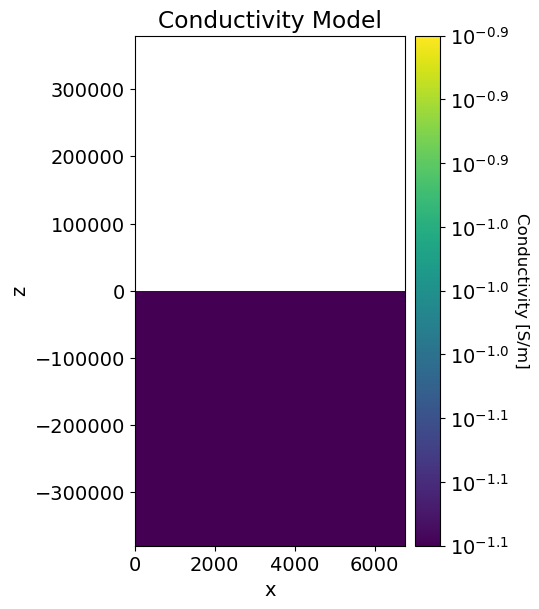

In [21]:
from discretize import CylindricalMesh
from discretize.utils import mkvc

from SimPEG import maps
import SimPEG.electromagnetics.time_domain as tdem

import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt

try:
    from pymatsolver import Pardiso as Solver
except ImportError:
    from SimPEG import SolverLU as Solver

write_file = False

waveform = tdem.sources.StepOffWaveform(off_time=0.0)

# Observation times for response (time channels)
time_channels = np.logspace(-4, -2, 11)

# Defining transmitter locations
xtx, ytx, ztx = np.meshgrid([0], [0], np.linspace(0, -500, 26) - 2.5)
source_locations = np.c_[mkvc(xtx), mkvc(ytx), mkvc(ztx)]
ntx = np.size(xtx)

# Define receiver locations
xrx, yrx, zrx = np.meshgrid([0], [0], np.linspace(0, -500, 26) - 2.5)
receiver_locations = np.c_[mkvc(xrx), mkvc(yrx), mkvc(zrx)]

source_list = []  # Create empty list to store sources

# Each unique location defines a new transmitter
for ii in range(ntx):
    # Define receivers at each location.
    dbzdt_receiver = tdem.receivers.PointMagneticFluxTimeDerivative(
        receiver_locations[ii, :], time_channels, "z"
    )
    receivers_list = [
        dbzdt_receiver
    ]  # Make a list containing all receivers even if just one

    # Must define the transmitter properties and associated receivers
    source_list.append(
        tdem.sources.CircularLoop(
            receivers_list,
            location=source_locations[ii],
            waveform=waveform,
            radius=10.0,
        )
    )

survey = tdem.Survey(source_list)

hr = [(5.0, 40), (5.0, 15, 1.5)]
hz = [(5.0, 25, -1.5), (5.0, 300), (5.0, 25, 1.5)]

mesh = CylindricalMesh([hr, 1, hz], x0="00C")

# Conductivity in S/m (or resistivity in Ohm m)
air_conductivity = 1e-8
background_conductivity = 1e-1
layer_conductivity_1 = 1e-1
layer_conductivity_2 = 1e-1

# Find cells that are active in the forward modeling (cells below surface)
ind_active = mesh.cell_centers[:, 2] < 0

# Define mapping from model to active cells
model_map = maps.InjectActiveCells(mesh, ind_active, air_conductivity)

# Define the model
model = background_conductivity * np.ones(ind_active.sum())
ind = (mesh.cell_centers[ind_active, 2] > -200.0) & (
    mesh.cell_centers[ind_active, 2] < -0
)
model[ind] = layer_conductivity_1
ind = (mesh.cell_centers[ind_active, 2] > -400.0) & (
    mesh.cell_centers[ind_active, 2] < -200
)
model[ind] = layer_conductivity_2

# Plot Conductivity Model
mpl.rcParams.update({"font.size": 14})
fig = plt.figure(figsize=(5, 6))

plotting_map = maps.InjectActiveCells(mesh, ind_active, np.nan)
log_model = np.log10(model)

ax1 = fig.add_axes([0.20, 0.1, 0.54, 0.85])
mesh.plot_image(
    plotting_map * log_model,
    ax=ax1,
    grid=False,
    clim=(np.log10(layer_conductivity_2), np.log10(layer_conductivity_1)),
)
ax1.set_title("Conductivity Model")

ax2 = fig.add_axes([0.76, 0.1, 0.05, 0.85])
norm = mpl.colors.Normalize(
    vmin=np.log10(layer_conductivity_2), vmax=np.log10(layer_conductivity_1)
)
cbar = mpl.colorbar.ColorbarBase(
    ax2, norm=norm, orientation="vertical", format="$10^{%.1f}$"
)
cbar.set_label("Conductivity [S/m]", rotation=270, labelpad=15, size=12)

simulation = tdem.simulation.Simulation3DMagneticFluxDensity(
    mesh, survey=survey, sigmaMap=model_map, solver=Solver
)



# Absolute Stability of the backward Euler Method
Now try this on backward Euler

$$
U_{n+1} = U_n + \Delta t f(t_{n+1}, U_{n+1}),
$$

The backward version of Euler's method is defined as
$$
    U_{n+1} = U_n + \Delta t f(t_{n+1}, U_{n+1})
$$

If we again consider the test problem from before we find that

$$  \begin{aligned}
    0 &= U_{n+1} (1 - \Delta t \lambda) - U_n \\\\
    &= \xi (1 - z) - 1
    \end{aligned}
$$
which has the root $\xi = \frac{1}{1 - z}$.  We then have
$$\left|\frac{1}{1-z}\right| \leq 1 \leftrightarrow |1 - z| \geq 1$$

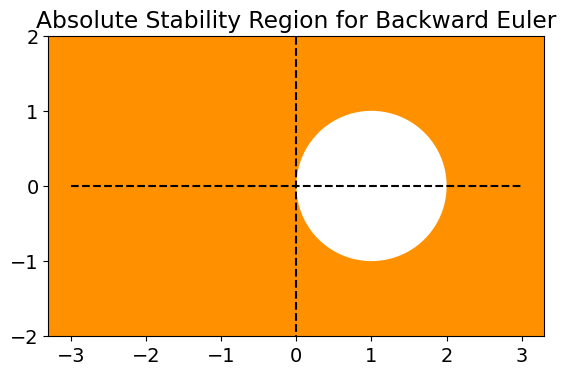

In [23]:
# Plot the region of absolute stability for Backward Euler
fig = plt.figure()
axes = fig.add_subplot(1, 1, 1)

t = np.linspace(0.0, 2.0 * np.pi, 100)

axes.set_facecolor((255.0/255.0,145.0/255.0,0/255.0,1.0))
axes.fill(np.cos(t) + 1.0, np.sin(t), 'w')
axes.plot([-3, 3],[0.0, 0.0],'k--')
axes.plot([0.0, 0.0],[-3, 3],'k--')
# axes.set_xlim((-3, 1))
axes.set_ylim((-2,2))
axes.set_aspect('equal')

axes.set_title("Absolute Stability Region for Backward Euler")
plt.show()

# Stability

Backward Euler has a stability region consisting of the entire left side of the complex plain which makes it particularly good at stiff problems. We can determine our formulation is stiff by analyzing to (4) and (5) without the source term and isolating b and doing a substitution to find that:

$$
 \frac{\partial{\textbf{b}}}{\partial{t}} + \nabla \times \left( \frac{1}{\sigma} \nabla \times \frac{1}{\mu} \textbf{b} \right) = 0
$$

and using the identity $\nabla \times (\nabla \times \textbf{b}) = \nabla(\nabla \cdot \textbf{b}) - \nabla^2 \textbf{b}$ but we have $\nabla \cdot \textbf{b} = 0$ which leaves us with:

$$
 \frac{\partial{\textbf{b}}}{\partial{t}} = \frac{1}{\mu \sigma}\nabla^2 \textbf{b}
$$

This resembles the heat equation. If we assume 1D and a homogeneous whole space and uniform cell size and move to a discrete form:

$$
\frac{\textbf{b}_n^{t+1} - \textbf{b}_n^t}{\Delta t} = \frac{1}{\mu \sigma} \frac{\textbf{b}_{n+1}^t - 2\textbf{b}_{n}^t + \textbf{b}_{n-1}^t}{\Delta h^2} 
$$

Using (23) we can derive that we need time step restriction of:

$$
\Delta_t \leq \frac{\mu \sigma \Delta h^2}{2}
$$

In [46]:
from scipy.constants import mu_0
1 / simulation.time_steps.sum()

sigma = 1e-1
dh = 5.0

delta_t = (mu_0 * sigma * dh**2) / 2
print(delta_t)

1.5707963276500001e-06


0.023050000000000005


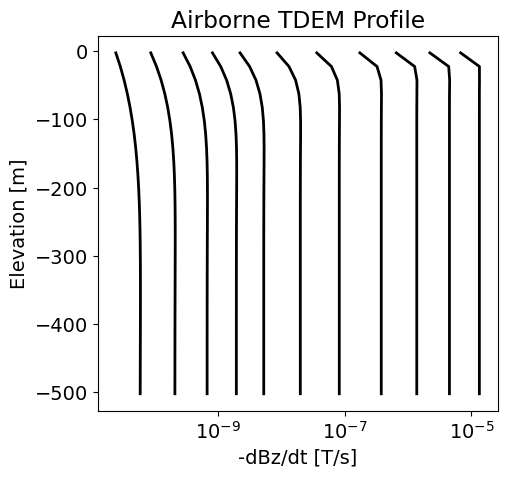

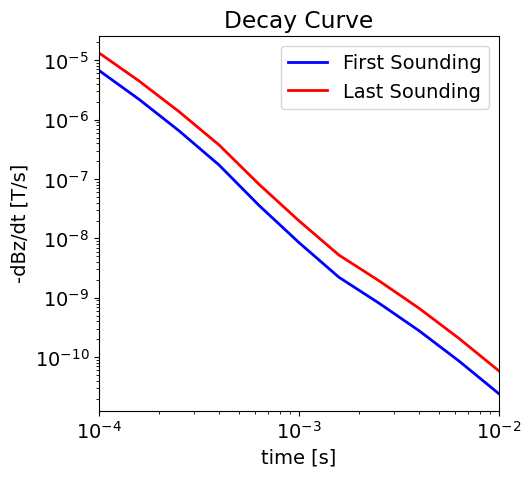

In [47]:
time_steps = [(5e-07, 100), (0.0001, 20), (0.001, 21)]

# Set the time-stepping for the simulation
simulation.time_steps = time_steps
print(simulation.time_steps.sum())
# Data are organized by transmitter, then by
# receiver then by observation time. dBdt data are in T/s.
dpred = simulation.dpred(model)

# Plot the response
dpred = np.reshape(dpred, (ntx, len(time_channels)))

# TDEM Profile
fig = plt.figure(figsize=(5, 5))
ax1 = fig.add_axes([0.15, 0.15, 0.8, 0.75])
for ii in range(0, len(time_channels)):
    ax1.semilogx(
        -dpred[:, ii], receiver_locations[:, -1], "k", lw=2
    )  # -ve sign to plot -dBz/dt
ax1.set_xlabel("-dBz/dt [T/s]")
ax1.set_ylabel("Elevation [m]")
ax1.set_title("Airborne TDEM Profile")

# Response for all time channels
fig = plt.figure(figsize=(5, 5))
ax1 = fig.add_axes([0.15, 0.15, 0.8, 0.75])
ax1.loglog(time_channels, -dpred[0, :], "b", lw=2)
ax1.loglog(time_channels, -dpred[-1, :], "r", lw=2)
ax1.set_xlim((np.min(time_channels), np.max(time_channels)))
ax1.set_xlabel("time [s]")
ax1.set_ylabel("-dBz/dt [T/s]")
ax1.set_title("Decay Curve")
ax1.legend(["First Sounding", "Last Sounding"], loc="upper right")

In [26]:
data_discretization = []

In [48]:
data_discretization.append(dpred)

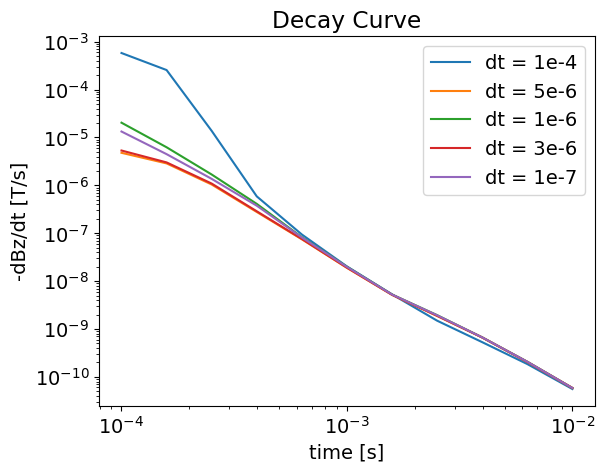

In [49]:
ids = ['dt = 1e-4', 'dt = 5e-6', 'dt = 1e-6', 'dt = 3e-6', 'dt = 1e-7']
for ii in range(5):

    plt.loglog(time_channels, -data_discretization[ii][-1, :], label=ids[ii])

# plt.xlim((np.min(time_channels), np.max(time_channels)))
plt.xlabel("time [s]")
plt.ylabel("-dBz/dt [T/s]")
plt.title("Decay Curve")
plt.legend()
plt.show()